Various reaching tasks with planar manipulator modeled in single notebook

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np 

from planar_manipulator import PlanarManipulator
from plot_utils import plot_chain

np.set_printoptions(3, suppress=True)
torch.set_printoptions(3, sci_mode=False)

import sys
sys.path.append('../')
from ttgo import TTGO
import tt_utils

from cost_utils import PlanarManipulatorCost
from utils import Point2PointMotion

import warnings
warnings.filterwarnings('ignore')


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-rax94yrt because the default path (/idiap/home/sshetty/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
file_name = None # trained model

In [4]:
# Define the robot
n_joints = 2
link_lengths = torch.tensor([1./n_joints]*n_joints).to(device)
max_theta = torch.pi
min_theta = -1*max_theta
n_kp = 10;
dt = 0.02;
d0_x = 30; d0_theta = 30; d0_w = 30;
# Define the environment and the task (Cost function)
x_obst = [torch.tensor([-0.3,-0.]).to(device).to(device)]#,torch.tensor([0.5,0.])]
r_obst = [0.175]*1

# x_obst = [torch.tensor([-0.35,-0.]).to(device),torch.tensor([-0.95,-0.]).to(device)]#,torch.tensor([0.5,0.])]
# r_obst = [0.2]*2
# x_obst = [torch.tensor([-0.35,-0.25]).to(device),torch.tensor([-0.95,-0.]).to(device)]#,torch.tensor([0.5,0.])]
# r_obst = [0.1]*2
margin=0.02
w_goal= 1; w_obst=1; w_ee=0.; w_control=1;
b_goal=0.25;b_obst=4; b_ee=10; b_control=4.;

theta_0 = torch.tensor([2.1*torch.pi/4,-1.5*torch.pi/4]).to(device).view(1,-1)
theta_3 = 1*theta_0

K=2

robot = PlanarManipulator(n_joints=n_joints,link_lengths=link_lengths,max_theta=max_theta,n_kp=n_kp, device=device)
bounds = [robot.min_config, robot.max_config]
p2p_motion = Point2PointMotion(n=n_joints,dt=dt,K=K,basis='bs',bounds=bounds, device=device)
costPlanarManipulator = PlanarManipulatorCost(robot,p2p_motion=p2p_motion,x_obst=x_obst,r_obst=r_obst, margin=margin,
                                              w_goal=w_goal,w_obst=w_obst,w_ee=w_ee, w_control=w_control,
                                              b_goal=b_goal, b_obst=b_obst,b_ee=b_ee, b_control=b_control, device=device)

Define the domain and the cost functions

In [5]:
# Pick and place location (via-points: x_1 and x_2)
x_min_place = -0.75; x_max_place = -0.5;
y_min_place = -0.5; y_max_place = 0.5;

x_min_pick =  0.5; x_max_pick = 0.75;
y_min_pick = -0.5; y_max_pick = 0.5;

d0_y = int(d0_x/5);
domain_x1 = [torch.linspace(x_min_pick,x_max_pick,d0_x).to(device),
            torch.linspace(y_min_pick,y_max_pick,d0_y).to(device)]
domain_x2= [torch.linspace(x_min_place,x_max_place,d0_x).to(device),
            torch.linspace(y_min_place,y_max_place,d0_y).to(device)]

domain_theta = [torch.linspace(min_theta, max_theta,d0_theta).to(device)]*n_joints
domain_w = [torch.linspace(min_theta,max_theta,d0_w).to(device)]*(K*n_joints)


task = 'reaching'
domain_task = domain_x2
domain_decision = domain_theta + domain_w
domain = domain_task+domain_decision
domain = [x.to(device) for x in domain]
def cost(x):
    # x: (x_task, theta_1, w01)
    return costPlanarManipulator.cost_j2p(x,theta_0)[:,0]

def cost_to_print(x):
    # x: (x_task,theta_1,w01)
    return costPlanarManipulator.cost_j2p(x,theta_0)

def pdf_goal(x):
    # x: (x_task, theta_1)
    d_goal = costPlanarManipulator.cost_goal(x)#costPlanarManipulator.cost_ik(x)[:,1]
    return torch.exp(-(d_goal/0.25)**2) 


def pdf_obst(x):
    # x: (theta_1, w01)
    d_obst = costPlanarManipulator.cost_obst(x,theta_0)#costPlanarManipulator.cost_ik(x)[:,1]
    return torch.exp(-(d_obst/100)**2) 


def pdf_control(x):
    # x: (theta_1,w01)
    d_control = costPlanarManipulator.cost_control(x,theta_0)#costPlanarManipulator.cost_ik(x)[:,1]
    return torch.exp(-(d_control/4)**2) 


print("Find tt_model of pdf_goal:")
domain_goal = domain_x2 + domain_theta
tt_goal = tt_utils.cross_approximate(fcn=pdf_goal,  domain=domain_goal, 
                        rmax=100, nswp=20, eps=1e-3, verbose=True, 
                        kickrank=5, device=device)

print("Find tt_model of pdf_control:")
domain_control = domain_theta + domain_w
tt_control = tt_utils.cross_approximate(fcn=pdf_control,  domain=domain_control, 
                        rmax=50, nswp=20, eps=1e-3, verbose=True, 
                        kickrank=5, device=device)

print("Find tt_model of pdf_obst:")
domain_obst = domain_theta + domain_w
tt_obst = tt_utils.cross_approximate(fcn=pdf_obst,  domain=domain_obst, 
                        rmax=50, nswp=20, eps=1e-3, verbose=True, 
                        kickrank=5, device=device)


# make sure the dimensions of the tt models matches with that of tt_model desired by adding dummy variables/cores

tt_goal = tt_utils.extend_model(tt_model=tt_goal,site=-1,n_cores=len(domain_w),d=[d0_w]*len(domain_w)).to(device)
tt_obst = tt_utils.extend_model(tt_model=tt_obst,site=0,n_cores=2,d=[d0_x]*2).to(device)
tt_control = tt_utils.extend_model(tt_model=tt_control,site=0,n_cores=2,d=[d0_x]*2).to(device)

print("Take product: pdf(x_task,x_decision) = pdf_goal(x_task,x_decision)*pdf_obst(x_decision)*pdf_obst(x_decision)")
tt_model = tt_goal.to('cpu')*tt_control.to('cpu')
tt_model.round_tt(1e-3) 
tt_model = tt_model*tt_obst.to('cpu')
tt_model.round_tt(1e-3) 


domain = domain_task+domain_decision
domain = [x.to(device) for x in domain]



Find tt_model of pdf_goal:
cross device is cuda
Cross-approximation over a 4D domain containing 162000 grid points:
iter: 0  | tt-error: 1.001e+00, test-error:9.709e-01 | time:   1.2827 | largest rank:   1
iter: 1  | tt-error: 3.314e+00, test-error:5.890e-01 | time:   1.3099 | largest rank:   6
iter: 2  | tt-error: 6.617e-01, test-error:2.992e-01 | time:   1.3406 | largest rank:  11
iter: 3  | tt-error: 3.404e-01, test-error:6.321e-02 | time:   1.3779 | largest rank:  16
iter: 4  | tt-error: 6.149e-02, test-error:2.027e-02 | time:   1.4208 | largest rank:  21
iter: 5  | tt-error: 2.034e-02, test-error:1.449e-03 | time:   1.4693 | largest rank:  26
iter: 6  | tt-error: 1.448e-03, test-error:2.160e-04 | time:   1.5238 | largest rank:  31
iter: 7  | tt-error: 2.098e-04, test-error:3.138e-05 | time:   1.5801 | largest rank:  36 <- converged: eps < 0.001
Did 267642 function evaluations, which took 0.08747s (3.06e+06 evals/s)

Find tt_model of pdf_control:
cross device is cuda
Cross-approxim

In [6]:
# Refine the discretization and interpolate the model
scale_factor = 10
site_list = torch.arange(len(domain))#len(domain_task)+torch.arange(len(domain_decision))
domain_new = tt_utils.refine_domain(domain=domain, 
                                    site_list=site_list,
                                    scale_factor=scale_factor, device=device)
tt_model_new = tt_utils.refine_model(tt_model=tt_model.to(device), 
                                    site_list=site_list,
                                    scale_factor=scale_factor, device=device)

In [7]:
ttgo = TTGO(tt_model=tt_model_new.to(device), domain=domain_new,cost=cost, device=device)

In [8]:
# # Either load a trained model or train a new model:
# if not (file_name is None):
#     # Load the trained model and the system params:
#     model = torch.load(file_name)
#     ttgo.tt_model = model['tt_model']; ttgo.to('cpu')
#     w_goal, w_obst, w_ee, w_control = model['w']
#     b_goal, b_obst, b_ee, b_control = model['b']
#     margin = model['margin']
#     domain = model['domain']
#     x_obst= model['x_obst']
#     r_obst = model['r_obst']
#     n_joints = model['n_joints']
#     n_kp = model['n_kp']
#     dt = model['dt']
#     theta_0 = model['theta_0']
#     theta_3 = model['theta_3']
# else:
#     ttgo.cross_approximate(rmax=100, nswp=5, kickrank=3)

In [9]:
# generate test set
ns = 50
test_task = torch.zeros(ns,len(domain_task)).to(device)
for i in range(len(domain_task)):
    unif = torch.distributions.uniform.Uniform(low=domain_task[i][0],high=domain_task[i][-1])
    test_task[:,i]= torch.tensor([unif.sample() for i in range(ns)]).to(device)


In [10]:
# # Save the model for future purpose
# torch.save({
#     'tt_model':ttgo.tt_model,
#     'w': (w_goal,w_obst,w_ee,w_control),
#     'b': (b_goal,b_obst,b_ee,b_control),
#     'margin': margin,
#     'domain': domain,
#     'test_task': test_task,
#     'x_obst':x_obst,
#     'r_obst':r_obst,
#     'n_joints':n_joints,
#     'n_kp':10,
#     'dt':0.02,
#     'theta_0':theta_0,
#     'theta_3':theta_3
# }, 'planar_via_2.pickle')

In [11]:
# n_samples_tt = 100
# alpha = 0.9
# norm=1
# print("total-cost | dist-to-goal | collision-cost | ee-cost | control-cost ")
# from utils import test_ttgo
# _ = test_ttgo(ttgo=ttgo.clone(), cost=cost_to_print, test_task=test_task, n_samples_tt=n_samples_tt, 
#      alpha=alpha, device='cpu', test_rand=True)


## Visualization

In [15]:
k = np.random.choice(np.arange(ns))
x_task = test_task[k].view(1,-1).to(device)
# samples, samples_idx = ttgo.sample_random(n_samples=1000, x_task=x_task)
samples= ttgo.sample_tt(n_samples=100, x_task=x_task, alpha=0.75)
state_tt = ttgo.choose_best_sample(samples)[0]
state_tt_opt, _ = ttgo.optimize(state_tt.to("cpu"))
state_tt_opt = state_tt.to(device)
x = 1*state_tt_opt.reshape(1,-1)


In [16]:

batch_size = x.shape[0]
x_goal_1 = x[:,:2] # desired position of ee at via point
theta_1 = x[:,2:2+n_joints] # via configuration
w = x[:,2+n_joints:] # weights of the basis function
w01 = w[:,:int(w.shape[-1])] # weights for the first part of the motion: theta_0 to theta_1 
theta_t_01 = p2p_motion.gen_traj_p2p(theta_0.view(1,-1).repeat(batch_size,1),theta_1,w01)#batchxtimexjoint_angle
T01 = theta_t_01.shape[1]
kp_loc_t_01, joint_loc_t_01, ee_loc_t_01,_ = robot.forward_kin(theta_t_01.view(-1,n_joints))
joint_loc = joint_loc_t_01.view(batch_size,T01,*joint_loc_t_01.shape[1:])[0].cpu()
x_target = [x_goal_1.view(-1).cpu().numpy()]


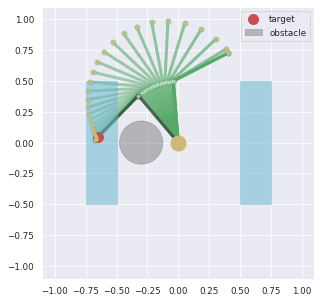

In [17]:
x_obst_np = [x.cpu().numpy() for x in x_obst]
link_lengths_np = link_lengths.cpu().numpy()
rect_patch = [[x_min_pick,y_min_pick, x_max_pick-x_min_pick,  y_max_pick-y_min_pick],
              [x_min_place,y_min_place, x_max_place-x_min_place,  y_max_place-y_min_place]]
plt=plot_chain(joint_loc=joint_loc, link_lengths=link_lengths_np, x_obst=x_obst_np,
               r_obst=r_obst, rect_patch=rect_patch, x_target=x_target, 
               batch=True, figsize=5, skip_frame=2, title=None, save_as=None, 
               color_intensity=0.9, motion=True, alpha=0.8, 
               contrast=0.4, idx_highlight=[int(joint_loc.shape[0]-1)], lw=3, task=task)
# plt.savefig("reach-2d-tt-opt-7.png",dpi=300, pad_inches=0.01)